In [1]:
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime
from scipy import signal, stats, interpolate, optimize, ndimage
from skimage import morphology
import matplotlib.lines as mlines
import matplotlib.colors as colors
import seaborn as sns
import pickle
import os
from scipy.io import savemat
import scipy.io as scio
import colorcet as cc
import skimage.io as skio
import importlib

biopubs_style = Path(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(
    biopubs_style
)
warnings.filterwarnings("once")

In [2]:
expt_name = "20221011_nkx_intensity"
rootdir = Path(os.getenv("DATA_ROOTDIR"), expt_name)
output_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure5/")
os.makedirs(output_datadir/expt_name, exist_ok=True)

Get mean cone size

Measurements are in pixels/voxels in this table

In [3]:
um_per_px = [0.207, 0.197, 0.197, 0.197, 0.197]

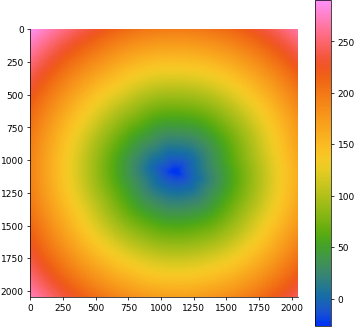

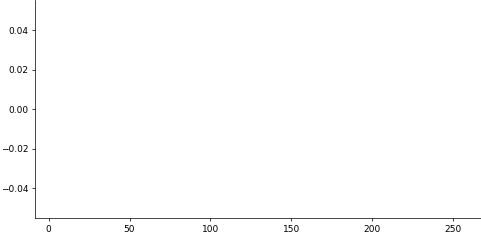

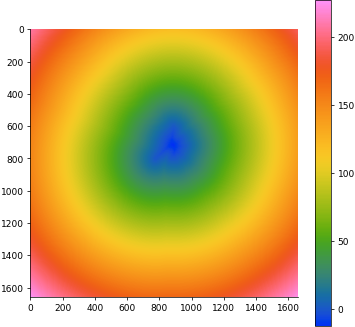

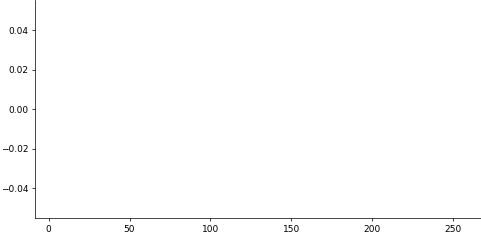

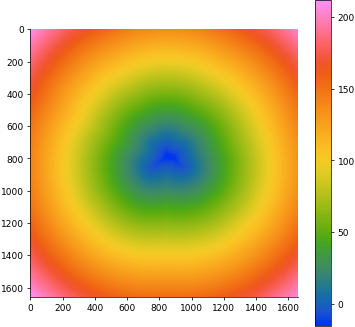

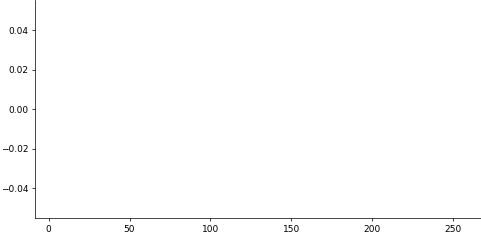

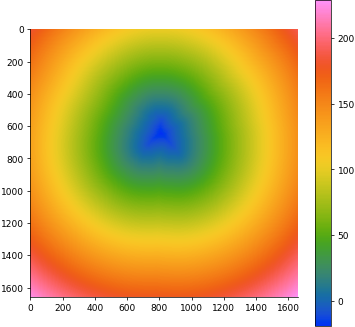

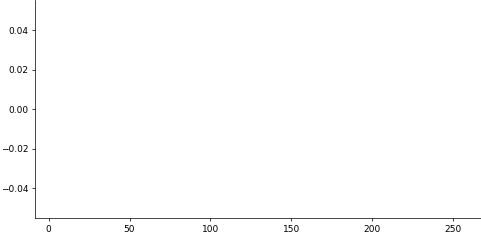

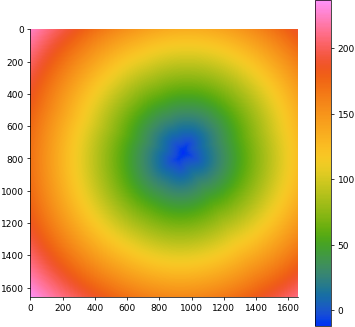

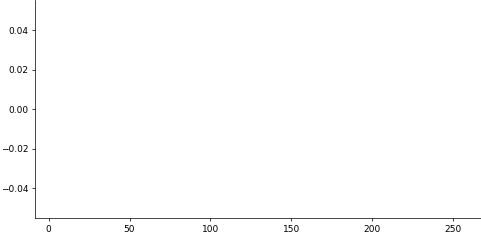

In [4]:
distance_intensity_dfs = []
for idx, embryo in enumerate(range(1,6)):
    cone_mask_name = "nkx2.5_zACNE20_20ss_E%d_mask.tif" % embryo
    nkx_mask = skio.imread(os.path.join(rootdir, cone_mask_name)).astype(bool)
    intensity = skio.imread(os.path.join(rootdir, "nkx2.5_zACNE20_20ss_E%d-01_MED_MAX.ome.tif")\
                            % embryo)[0]
    max_int = np.nanpercentile(intensity, 99.5)
    intensity[intensity>max_int] = max_int
    intensity = intensity/max_int
    
    edge = nkx_mask & ~morphology.binary_erosion(nkx_mask, morphology.disk(3))
    distances = ndimage.morphology.distance_transform_edt(~edge, sampling=um_per_px[idx])
    distances[nkx_mask] *= -1
    fig1, ax1 = plt.subplots(figsize=(6,6))
    distance_intensity_dfs.append(pd.DataFrame({"embryo": [embryo]*distances.ravel().shape[0],
                                                "distance":distances.ravel(), 
                                                "intensity":intensity.ravel()}))
    q = ax1.imshow(distances)
    plt.colorbar(q)
    fig2, ax2 = plt.subplots(figsize=(8,4))
    ax2.hist(intensity.ravel(), bins=np.linspace(4,255,50))

In [5]:
df = pd.concat(distance_intensity_dfs, axis=0)

In [21]:
df.to_csv(output_datadir/"nkx_intensity_vs_cone_distance.csv")

In [6]:
df["bin"], bins = pd.cut(df.distance, 100, labels=False, retbins=True)

In [ ]:
df[]

In [10]:
bin_middles = bins[:-1] + np.diff(bins)/2

In [7]:
moving_mean_intensity = df.groupby("bin")["intensity"].mean()
moving_std_intensity = df.groupby("bin")["intensity"].std()
moving_sem_intensity = moving_std_intensity/np.sqrt(df.groupby("bin")["intensity"].count())

In [11]:
summary_df = pd.DataFrame({"dist_um": bin_middles,
                          "mean_intensity": moving_mean_intensity,
                          "sem": moving_sem_intensity})

In [13]:
summary_df.to_csv(output_datadir/"nkx_intensity_vs_cone_distance.csv")

In [58]:
moving_sem_intensity

bin
0     0.000633
1     0.000421
2     0.000277
3     0.000349
4     0.000367
        ...   
95    0.000000
96    0.000003
97    0.000000
98    0.000000
99    0.000021
Name: intensity, Length: 100, dtype: float64

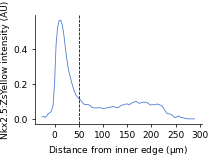

In [64]:
fig1, ax1 = plt.subplots(figsize=(3,2))
ax1.plot(bin_middles, moving_mean_intensity)
ax1.fill_between(bin_middles, moving_mean_intensity-moving_sem_intensity,\
                 moving_mean_intensity+moving_sem_intensity, alpha=0.1)
ax1.set_xlabel(r"Distance from inner edge ($\mathrm{\mu m}$)")
ax1.set_ylabel("Nkx2.5:ZsYellow intensity (AU)")
ax1.set_xticks([0,50,100,150,200,250,300])
ax1.axvline(50, linestyle="--", color="k")
plt.savefig(os.path.join(figdir, "Supplementary Figures", "cone_geometry", "nkx_intensity.svg"))